In [8]:
import Diagrams.Prelude
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler.Strict
import Control.Monad.Bayes.Traced.Static
import Numeric.Log
import qualified Diagrams.Backend.Cairo as C
import Control.Monad
import qualified Control.Monad.Bayes.Weighted as Weighted
import Control.Monad.Bayes.Density.Free
import Control.Monad.Writer

{-# LANGUAGE NoMonomorphismRestriction #-}
{-# LANGUAGE FlexibleContexts          #-}
{-# LANGUAGE TypeFamilies              #-}

ideas:

sample from the space of linear maps, and apply to a square

show wigner semicircle distribution

create grammar of shapes, with duplication, mirroring and fancier things

probabilistic language for declarative: a red square points at a red circle: really means: sample from the distribution induced by this!!

display factor graphs

the folding map: random transforms

sampling: show samples from normal

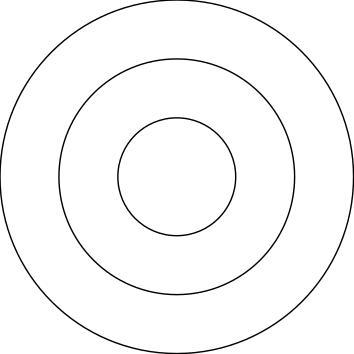

In [4]:
d n = do 
    x <- bernoulli 0.01
    if x then return $ mconcat (circle <$> [1..n]) else d (n + 1)
    
sampleIO (diagram <$> d 1)

Line 3: Functor law
Found:
fmap diagram
  $ fmap mconcat
      $ replicateM 10
          $ do x <- random
               y <- Control.Monad.Bayes.Class.normal 0 1
               z <- Control.Monad.Bayes.Class.normal 0 1
               factor (if 2 * y > z then 1 else 0.001)
               return (eqTriangle 0.5 # rotateBy x # translate (V2 y z))
Why not:
fmap
  (diagram . mconcat)
  (replicateM 10
     $ do x <- random
          y <- Control.Monad.Bayes.Class.normal 0 1
          z <- Control.Monad.Bayes.Class.normal 0 1
          factor (if 2 * y > z then 1 else 0.001)
          return (eqTriangle 0.5 # rotateBy x # translate (V2 y z)))

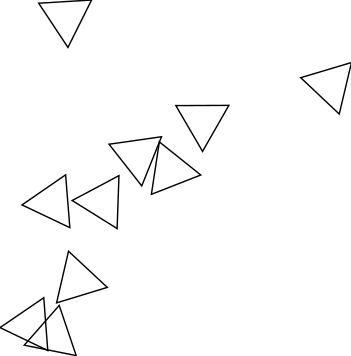

In [4]:

fmap head $ sampleIO $ prior $ mh 100 $ fmap diagram $ fmap mconcat $ replicateM 10 $ do
        x <- random
        y <- Control.Monad.Bayes.Class.normal 0 1
        z <- Control.Monad.Bayes.Class.normal 0 1
        -- condition (y > 0.01 )
        factor (if 2*y > z then 1 else 0.001)
        return (eqTriangle 0.5 # rotateBy x # translate (V2 y z) )

In [39]:
getTrace :: Weighted (Density SamplerIO) a -> SamplerIO ([Double], Log Double)
getTrace m = fmap (\((x,y),z) -> (z,y) ) $ runWriterT $ weighted $ Weighted.hoist (WriterT . density []) m

In [40]:
program = do
    x <- beta 1 2
    b <- Control.Monad.Bayes.Class.normal (x**2) 1
    factor $ normalPdf 0 ( abs b) x
    return b

-- program = do 
--     y <- gamma 2 2
--     x <- Control.Monad.Bayes.Class.normal 0 1
    
--     z <- Control.Monad.Bayes.Class.normal 0 1
--     factor $ normalPdf x y z
--     return x
--     -- factor $ normalPdf 0 1 (x + y)
    -- if y > 0.99 then program else return 2

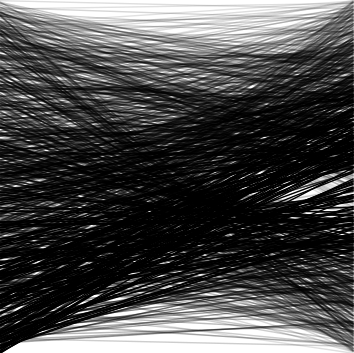

In [43]:

traceDiagram :: ([Double], Log Double) -> Diagram C.B
traceDiagram (trace, weight) = fromVertices [p2 (i,y) | (y,i) <- zip trace [1..]] # opacity (ln $ exp weight) # scaleX 1

sampleIOfixed $ fmap (diagram . mconcat . fmap traceDiagram) $ replicateM 1000 $ getTrace program


In [38]:
sizedText str = text str <> rect 10 2 # opacity 0 # frame 0.1
scale = vsep 1 $ map (sizedText . show) [1 :: Float,0.9..0]



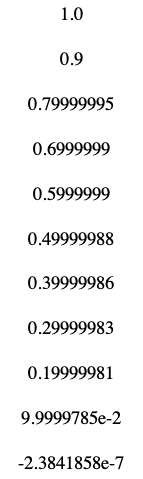

In [39]:
diagram scale